In [18]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator


In [19]:
# 创建SparkSession
spark = SparkSession.builder.appName('Demand Prediction').getOrCreate()

from pyspark.sql.functions import col

In [20]:
# 导入数据
data = spark.read.format("csv").option("header", "true").load("data/data_sample.csv")

In [21]:
# Convert the 'demand' column to a numeric type
data = data.withColumn("demand", col("demand").cast("double"))
# 数据清洗和准备
data = data.dropna()
data = data.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("year", year(col("timestamp")))
data = data.withColumn("month", month(col("timestamp")))
data = data.withColumn("day", dayofmonth(col("timestamp")))

In [22]:
# 特征工程
assembler = VectorAssembler(inputCols=["year", "month", "day"], outputCol="features")
data = assembler.transform(data)

# 划分训练和测试数据集
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

In [23]:
# 定义线性回归模型
lr = LinearRegression(featuresCol="features", labelCol="demand")

# 训练模型
lr_model = lr.fit(train_data)

# 预测未来需求
predictions = lr_model.transform(test_data)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()



23/03/03 01:33:32 WARN Instrumentation: [c3fa84db] regParam is zero, which might cause numerical instability and overfitting.
23/03/03 01:33:32 WARN Instrumentation: [c3fa84db] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
+----+-----+---+------+------------------+
|year|month|day|demand|        prediction|
+----+-----+---+------+------------------+
|2022|    1|  1| 200.0|1045.4444444444441|
|2022|    1|  1| 340.0|1045.4444444444441|
|2022|    1|  1| 360.0|1045.4444444444441|
|2022|    1|  1|4203.0|1045.4444444444441|
|2022|    1|  1|4603.0|1045.4444444444441|
|2022|    1|  1|1140.0|1045.4444444444441|
|2022|    1|  2|5360.0|1812.9259259259265|
|2022|    1|  2|3660.0|1812.9259259259265|
|2022|    1|  3|3160.0|2580.4074074074088|
+----+-----+---+------+------------------+



In [24]:
# 创建随机森林回归模型
rf = RandomForestRegressor(featuresCol="features", labelCol="demand", numTrees=10)

# 训练模型
rf_model = rf.fit(train_data)

# 预测未来需求
predictions = rf_model.transform(test_data)

# 计算模型的评估指标（均方误差）
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()

# 输出均方误差
print("Mean Squared Error (MSE) on test data = %g" % mse)


23/03/03 01:33:33 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 23 (= number of training instances)
+----+-----+---+------+------------------+
|year|month|day|demand|        prediction|
+----+-----+---+------+------------------+
|2022|    1|  1| 200.0|1157.0796144135725|
|2022|    1|  1| 340.0|1157.0796144135725|
|2022|    1|  1| 360.0|1157.0796144135725|
|2022|    1|  1|4203.0|1157.0796144135725|
|2022|    1|  1|4603.0|1157.0796144135725|
|2022|    1|  1|1140.0|1157.0796144135725|
|2022|    1|  2|5360.0| 1224.956237790196|
|2022|    1|  2|3660.0| 1224.956237790196|
|2022|    1|  3|3160.0| 2251.109159868118|
+----+-----+---+------+------------------+

Mean Squared Error (MSE) on test data = 5.24726e+06


In [25]:
# 创建梯度提升树回归模型
gbt = GBTRegressor(featuresCol="features", labelCol="demand", maxIter=10)

# 训练模型
gbt_model = gbt.fit(train_data)

# 预测未来需求
predictions = gbt_model.transform(test_data)

# 计算模型的评估指标（均方误差）
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()

# 输出均方误差
print(" 3 Mean Squared Error (MSE) on test data = %g" % mse)

23/03/03 01:33:33 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 23 (= number of training instances)
+----+-----+---+------+-----------------+
|year|month|day|demand|       prediction|
+----+-----+---+------+-----------------+
|2022|    1|  1| 200.0|1223.214285714285|
|2022|    1|  1| 340.0|1223.214285714285|
|2022|    1|  1| 360.0|1223.214285714285|
|2022|    1|  1|4203.0|1223.214285714285|
|2022|    1|  1|4603.0|1223.214285714285|
|2022|    1|  1|1140.0|1223.214285714285|
|2022|    1|  2|5360.0|983.3333333333334|
|2022|    1|  2|3660.0|983.3333333333334|
|2022|    1|  3|3160.0|           3410.0|
+----+-----+---+------+-----------------+

 3 Mean Squared Error (MSE) on test data = 5.47371e+06


In [26]:
print('#'*20)
import matplotlib.pyplot as plt

# 使用三种不同的模型进行预测
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# 使用均方误差评估每个模型的预测效果
lr_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
lr_mse = lr_evaluator.evaluate(lr_predictions)
rf_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
rf_mse = rf_evaluator.evaluate(rf_predictions)
gbt_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
gbt_mse = gbt_evaluator.evaluate(gbt_predictions)



####################


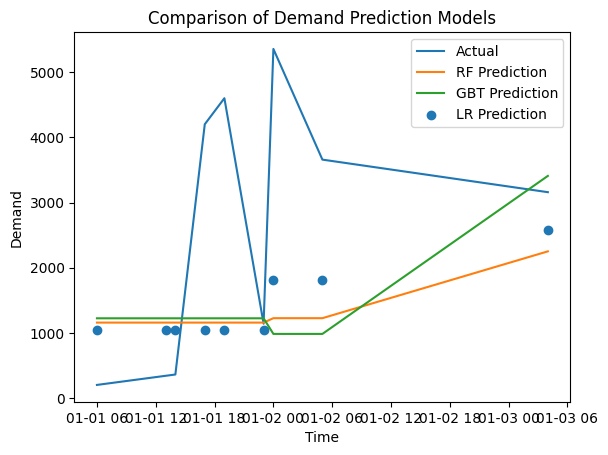

Linear Regression Mean Squared Error (MSE) on test data = 4.51632e+06
Random Forest Mean Squared Error (MSE) on test data = 5.24726e+06
Gradient Boosting Tree Mean Squared Error (MSE) on test data = 5.47371e+06


In [27]:
# 创建一个时间序列的数组
time_series = test_data.select("timestamp").rdd.flatMap(lambda x: x).collect()

# Create a matplotlib chart and plot the actual demand and predictions from each model
fig, ax = plt.subplots()
ax.plot(time_series, test_data.select("demand").collect(), label="Actual")
ax.plot(time_series, rf_predictions.select("prediction").collect(), label="RF Prediction")
ax.plot(time_series, gbt_predictions.select("prediction").collect(), label="GBT Prediction")
ax.scatter(time_series, lr_predictions.select("prediction").collect(), label="LR Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Comparison of Demand Prediction Models")
ax.legend()

# Show the chart
plt.show()


# 输出评估结果
print("Linear Regression Mean Squared Error (MSE) on test data = %g" % lr_mse)
print("Random Forest Mean Squared Error (MSE) on test data = %g" % rf_mse)
print("Gradient Boosting Tree Mean Squared Error (MSE) on test data = %g" % gbt_mse)
